In [10]:
#For Google Collab

from google.colab import drive
drive.mount('/content/drive')

!unzip '/content/drive/MyDrive/fyp/Dataset/WaterBodies_Dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: WaterBodiesDataset/Images/water_body_1809.jpg  
  inflating: WaterBodiesDataset/Images/water_body_1810.jpg  
  inflating: WaterBodiesDataset/Images/water_body_1811.jpg  
  inflating: WaterBodiesDataset/Images/water_body_1812.jpg  
  inflating: WaterBodiesDataset/Images/water_body_1813.jpg  
  inflating: WaterBodiesDataset/Images/water_body_1814.jpg  
  inflating: WaterBodiesDataset/Images/water_body_1815.jpg  
  inflating: WaterBodiesDataset/Images/water_body_1816.jpg  
  inflating: WaterBodiesDataset/Images/water_body_1817.jpg  
  inflating: WaterBodiesDataset/Images/water_body_1818.jpg  
  inflating: WaterBodiesDataset/Images/water_body_1819.jpg  
  inflating: WaterBodiesDataset/Images/water_body_182.jpg  
  inflating: WaterBodiesDataset/Images/water_body_1820.jpg  
  inflating: WaterBodiesDataset/Images/water_body_1822.jpg  
  inflating: WaterBodiesDataset/Images/water_body_1823.jpg  
  inflating: WaterBodiesDataset/Ima

In [3]:
#Required Dependencies

!pip install --upgrade opencv-contrib-python
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 MB 13.3 MB/s eta 0:00:00
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.8.0.76
    Uninstalling opencv-contrib-python-4.8.0.76:
      Successfully uninstalled opencv-contrib-python-4.8.0.76
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=ebbeb17eedde7553bc7b341e8d2664ff451a89b6390e2bfa12205e02f40e95d3
  Stored in directory: /root/.cache

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import glob
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from albumentations import HorizontalFlip, VerticalFlip, Rotate
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.image as mpimg
import albumentations as A

height,width = (256, 256) # Dimensions for Images


torch.cuda.is_available() # Checks if CUDA (NVIDIA parallel computing architecture) is available.

True

In [5]:
class LoadData(Dataset):
    def __init__(self, images_path, masks_path):
        super().__init__()

        # Path of images and masks from the dataset and the length of the images
        
        self.images_path = images_path
        self.masks_path = masks_path
        self.len = len(images_path)
        
        # Transformations done to each image
        self.transform = A.Compose([
            A.Resize(height,width),
            A.HorizontalFlip(),
            A.RandomBrightnessContrast(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        ])

    def __getitem__(self, idx):
        img = Image.open(self.images_path[idx])
        mask = Image.open(self.masks_path[idx]).convert('L')

        # Converts images to NumPy arrays for further processing

        img,mask=np.array(img),np.array(mask)

        # Applies transformation on the images

        transformed = self.transform(image=img, mask=mask)
        img = transformed['image']
        mask = transformed['mask']

        # Transposes the image and mask array and normalizes pixel values to the range [0, 1]

        img = np.transpose(img, (2, 0, 1))
        img = img/255.0
        img = torch.tensor(img)

        mask = np.expand_dims(mask, axis=0)
        mask = mask/255.0
        mask = torch.tensor(mask)

        return img, mask

    def __len__(self):
        return self.len

In [11]:
# For Google Collab

X = sorted(glob.glob('/content/WaterBodiesDataset/Images/*'))
y = sorted(glob.glob('/content/WaterBodiesDataset/Masks/*'))

# For Running Locally
#X = sorted(glob.glob('Dataset/WaterBodies_Dataset/WaterBodiesDataset/Images/*'))
#y = sorted(glob.glob('Dataset/WaterBodies_Dataset/WaterBodiesDataset/Masks/*'))

In [12]:
# Number of masks in the array
len(y)

2841

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [14]:
train_dataset = LoadData(X_train, y_train)
valid_dataset = LoadData(X_val, y_val)

# New Section

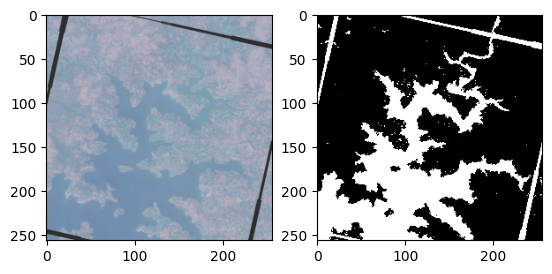

In [15]:
#  Retrieves a single sample from the training dataset using index 18.
img, mask = train_dataset[18]

# Creates a subplot with two axes
# Displays the mask image in the second axis, squeezing the mask tensor to remove singleton dimensions and using grayscale colormap.
# Displays the input image in the first axis after transposing the image tensor to the correct format for visualization.

f, axarr = plt.subplots(1,2)
axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
axarr[0].imshow(np.transpose(img.numpy(), (1,2,0)))

In [16]:
DEVICE='cuda' # Specifies that the device for training will be GPU ('cuda'). If not available, you might want to change it to 'cpu'.

EPOCHS=45 #  An epoch is one complete pass through the entire training dataset.
BATCH_SIZE=32 # The batch size of 32 means that the model will update its weights after processing 32 samples.
LR=0.001 # The learning rate determines the size of the steps taken during optimization. A smaller learning rate may lead to slower but more stable training.

ratio=0.5 # Pixels with predicted values greater than this ratio will be considered part of the water body.
sample_num=18 # Specifies the index of the sample from the dataset that will be used for visualization during evaluation.

ENCODER='resnet50' # Specifies the encoder architecture for the U-Net model.
WEIGHTS='imagenet' # Specifies the weight initialization for the encoder. 'imagenet' indicates that pre-trained weights from ImageNet will be used.

In [17]:
# DataLoader is a PyTorch class that provides an iterable over a dataset. It loads batches of data in parallel during training.
# Difference b/w train and valid loader is shuffle, shuffle is false in valid_loader as it goal is to evaluate model against unseen data

train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
)

valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
)

In [18]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [19]:
# This class will serve as the architecture for your segmentation model.

class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel,self).__init__()

        self.arc=smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None
        )
    
    # This method defines the forward pass of the model.
    
    def forward(self,images,masks=None):
        logits=self.arc(images)

        if masks!=None:
            loss1=DiceLoss(mode='binary')(logits,masks) # Calculates the Dice loss for binary segmentation.
            loss2=nn.BCEWithLogitsLoss()(logits,masks) # Calculates the Binary Cross-Entropy loss with logits.
            return logits,loss1,loss2
        return logits
    
# A Dice coefficient of 1 indicates a perfect match between the predicted and ground truth masks, while a coefficient of 0 indicates no overlap.

In [20]:
# Creates an instance of the SegmentationModel class and moves the model to the specified device (either GPU or CPU)

model=SegmentationModel()
model.to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 200MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReL

In [25]:
# This function is a training loop for your segmentation model

def train_fn(data_loader,model,optimizer):
    # Sets the model in training mode. This is important because certain layers, like dropout and batch normalization, behave differently during training compared to evaluation.
    model.train()

    total_diceloss = 0.0
    total_bceloss = 0.0

    for images ,masks in tqdm(data_loader):
        # Ensures that all images and masks are of the same data type

        images=images.to(DEVICE, dtype=torch.float32)
        masks=masks.to(DEVICE, dtype=torch.float32)

        # Clears the gradients of all optimized tensors. This is necessary before computing the gradients for a new batch.

        optimizer.zero_grad()

        # Logits refer to the raw, un-normalized predictions that a model generates for each class.
        logits,diceloss,bceloss=model(images,masks) # Calls forward method to compute the diceloss and bceloss.
        diceloss.backward(retain_graph=True) # Computes the gradients of the loss with respect to the model parameters.
        bceloss.backward()
        optimizer.step() # Updates the model parameters using the computed gradients and the specified optimization algorithm.
        
        total_diceloss += diceloss.item()
        total_bceloss += bceloss.item()

    # Returns the average Dice loss and Binary Cross-Entropy loss over all batches in the data loader.
    return total_diceloss/len(data_loader),total_bceloss/len(data_loader)

In [21]:
def eval_fn(data_loader,model):
    # Sets the model in evaluation mode. This is important because certain layers, like dropout and batch normalization, behave differently during training compared to evaluation.
    model.eval()
    
    total_diceloss = 0.0
    total_bceloss = 0.0
    
    # torch.no_grad() is a context manager provided by PyTorch that allows you to perform operations without computing gradients.

    with torch.no_grad():
        for images ,masks in tqdm(data_loader):

            images=images.to(DEVICE, dtype=torch.float32)
            masks=masks.to(DEVICE, dtype=torch.float32)

            logits,diceloss,bceloss=model(images,masks)

            total_diceloss += diceloss.item()
            total_bceloss += bceloss.item()

        # Visualization
        for i in range(1):
            image,mask=next(iter(valid_loader)) # Gets the next batch of data from the validation loader.
            image=image[sample_num]
            mask=mask[sample_num]

            logits_mask=model(image.to('cuda', dtype=torch.float32).unsqueeze(0)) # Passes the input image through the model to obtain logits for the segmentation mask.

            # Applies the sigmoid activation function to the logits to obtain predicted probabilities and converts it into binary predictions by thresholding with the specified ratio.

            pred_mask=torch.sigmoid(logits_mask)
            pred_mask=(pred_mask > ratio) * 1.0

            # Creates a subplot with three images: the ground truth mask (axarr[1]), the original image (axarr[0]), and the predicted mask (axarr[2]).

            f, axarr = plt.subplots(1,3)
            axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
            axarr[0].imshow(np.transpose(image.numpy(), (1,2,0)))
            axarr[2].imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)))
            plt.show()

    return total_diceloss/len(data_loader),total_bceloss/len(data_loader)

In [22]:
# Choose b/w Stochastic Gradient Descent OR ADAM optimizer

optimizer=torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
# torch.optim.Adam(model.parameters(),lr=LR)

In [ ]:
# To check the working, execute every cell apart from this one. (This is the training so will take lot of time)

best_val_dice_loss=np.Inf
best_val_bce_loss=np.Inf

for i in range(EPOCHS):
    train_loss = train_fn(train_loader,model,optimizer)
    valid_loss = eval_fn(valid_loader,model)

    train_dice,train_bce=train_loss
    valid_dice,valid_bce=valid_loss

    print(f'Epochs:{i+1}\nTrain_loss --> Dice: {train_dice} BCE: {train_bce} \nValid_loss --> Dice: {valid_dice} BCE: {valid_bce}')

    # Check if the current validation losses are better than the previous best
    
    if valid_dice < best_val_dice_loss or valid_bce < best_val_bce_loss:
        # For Google Collab
        torch.save(model.state_dict(),'/content/drive/MyDrive/HydroLens/hydrolens_best_model.pt')

        # For Running Locally
        # torch.save(model.state_dict(),'hydrolens_best_model.pt')

        print('Model Saved')
        best_val_dice_loss=valid_dice
        best_val_bce_loss=valid_bce

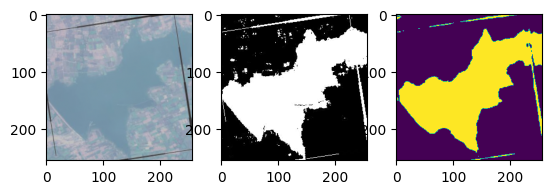

In [23]:
num=10 # Change for other images in the dataset (Choose number between 0 and 32(excluded))
ratio=0.5

# For Google Collab
model.load_state_dict(torch.load('/content/drive/MyDrive/fyp/hydrolens_best_model.pt'))

# For Running Locally
#model.load_state_dict(torch.load('hydrolens_best_model.pt'))

image,mask=next(iter(valid_loader))
image=image[num]
mask=mask[num]

logits_mask=model(image.to('cuda', dtype=torch.float32).unsqueeze(0)) # Perform a forward pass through the model to obtain the predicted mask

# Applies the sigmoid activation function to the logits to obtain predicted probabilities and converts it into binary predictions by thresholding with the specified ratio.

pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask > ratio)*1.0

# Creates a subplot with three images: the ground truth mask (axarr[1]), the original image (axarr[0]), and the predicted mask (axarr[2]).

f, axarr = plt.subplots(1,3)
axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
axarr[0].imshow(np.transpose(image.numpy(), (1,2,0)))
axarr[2].imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)))

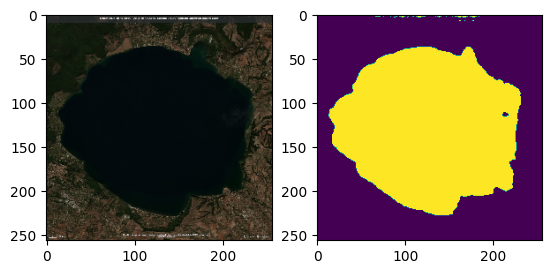

In [84]:
from PIL import Image
import torchvision.transforms as transforms

# Load your single satellite image
#image_path = '/content/drive/MyDrive/fyp/Satellite images/3/2023-10-25-00_00_2023-10-25-23_59_Sentinel-2_L2A_Highlight_Optimized_Natural_Color.jpg'
image_path = '/content/drive/MyDrive/fyp/Satellite images/1/2023-10-17-00_00_2023-10-17-23_59_Sentinel-2_L2A_True_color.jpg'
image = Image.open(image_path)

# Apply the same transformations used during training
transform = A.Compose([
     A.Resize(height,width),
     #Add any other transformations here
])

image = transform(image=np.array(image))['image']
image = np.transpose(image, (2, 0, 1)) / 255.0
image = torch.tensor(image).unsqueeze(0).to(DEVICE, dtype=torch.float32)

# Make a prediction
model.eval()
with torch.no_grad():
    logits = model(image)
    pred_mask = torch.sigmoid(logits)
    pred_mask = (pred_mask > ratio).float()

# Visualize the results

f, axarr = plt.subplots(1, 2)
axarr[0].imshow(np.transpose(image.squeeze().cpu().numpy(), (1, 2, 0)))

# Ensure pred_mask has the correct shape before visualization
pred_mask_np = pred_mask.squeeze().cpu().numpy()
if pred_mask_np.shape[-1] == 1:
    pred_mask_np = pred_mask_np.squeeze(-1)  # Remove the singleton channel dimension if present

axarr[1].imshow(pred_mask_np)
plt.show()

output_mask = Image.fromarray((pred_mask_np * 255).astype(np.uint8))
output_mask.save('/content/drive/MyDrive/fyp/predicted_mask.png')

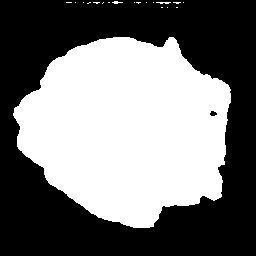

Area per pixel:  0.0006103515625
Water Surface area =  55.6329345703125  km sq


In [86]:
img = cv2.imread("/content/drive/MyDrive/fyp/predicted_mask.png")
cv2_imshow(img)

white_pix = np.sum(img == 255)
black_pix = np.sum(img == 0)


total_pix=black_pix+white_pix


img_irl_area=120 #irl area in km^

area_per_pix=img_irl_area/total_pix

print("Area per pixel: ",area_per_pix)
water_surface_area=white_pix*area_per_pix

print("Water Surface area = ",water_surface_area," km sq")